# 5. Training and Modelling Alternating Least Squares (ALS) and Logistic Matrix Factorization (LMF)<a id='5_Training_and_Modelling_ALS_and_LMF'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5. Training and Modelling ALS and LMF ](#5_Training_and_Modelling_ALS_and_LMF5)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Imports](#5.2_Imports)
  * [5.3 Load and Extract The Data](#5.3_Load_and_Extract_The_Data)
      * [5.3.1 Creating Sparse Matrix](#5.3.1_Creating_Sparse_Matrix)
  * [5.4 Modeling Using Alternating Least Squares (ALS)](#5.4_Modeling_Using_ALS)
  * [5.5 Modeling Using Logistic Matrix Factorization (LMF)](#5.5_Modeling_Using_LMF)
  * [5.6 Metrics and Evaluation](#5.6_Metrics_and_Evaluation)
       * [5.6.1 R_Precision](#5.6.1_R_Precision)
       * [5.6.2 Song Clicks](#5.6.2_Song_Clicks)
       * [5.6.3 Normalized Discounted Cumulative_Gain(NDCG)](#5.6.3_Normalized_Discounted_Cumulative_Gain)

## 5.2 Imports<a id='5.2_Imports'></a>

In [1]:
# ! pip install implicit

In [2]:
# Install and import other jupyter notebook
# !pip install ipynb
import import_ipynb


import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import glob, collections
import matplotlib.pyplot as plt
import scipy.sparse
import random
import implicit
import math

from sklearn.model_selection import train_test_split
from help_functions import *

importing Jupyter notebook from help_functions.ipynb


## 5.3 Load and Extract The Data<a id='5.3_Load_and_Extract_The_Data'></a>

In [3]:
read_files = glob.glob("spotify_million_playlist_dataset/data/*.json")

# Load the files into easy to manipulate json objects.
# We create a list of playlists, and a catalogue of unique tracks for the whole dataset.
# Example: playlist 7000 - playlist 7999
'''
Matrix size = n_playlists x n_tracks 

Example: 

Tracks id          fkh  lvi   oky   kai   dkf
     col_index     0    1     2     3     4
playlistid 
24
235
365
346
7376

'''

playlists_list = []
tracks_dict = {}       # key = track_uri, value = column index in matrix
playlists_dict = {}    # key = playlist pid, value = row index in matrix

test_data = {} # key = playlist_id, value = [column_ids]

data = []
rows = []
cols = []

i = 0
total_tracks_in_all_playlists = 0
for f in read_files:
    print(f)
    
    with open(f, "rb") as infile:
        json_data = json.load(infile)
        
        # At each playlist
        for playlist in json_data['playlists']:
            playlists_dict[playlist['pid']] = len(playlists_dict)
            playlists_list.append(playlist)
            
            train, test = train_test_split(playlist['tracks'], test_size=0.2, random_state=42)
            
            # This is for ALL of the data
            for track in playlist['tracks']:
                track_uri = track['track_uri']
                
                if track_uri not in tracks_dict:
                    tracks_dict[track_uri] = len(tracks_dict)
                
            for track in train:
                track_uri = track['track_uri']
                # Each track can appear in multiple rows, so this line is outside of the if-statement
                rows.append(playlists_dict[playlist['pid']])
                cols.append(tracks_dict[track_uri])
                data.append(float(1.0))
                
                total_tracks_in_all_playlists += 1
            
            playlist_id = playlists_dict[playlist['pid']]
            # Store a playlist ids with its list of tracks as column_ids in the test set 
            test_data[playlist_id] = [tracks_dict[test_song['track_uri']] for test_song in test]
                
    i += 1

spotify_million_playlist_dataset/data/mpd.slice.7000-7999.json
spotify_million_playlist_dataset/data/mpd.slice.3000-3999.json
spotify_million_playlist_dataset/data/mpd.slice.6000-6999.json
spotify_million_playlist_dataset/data/mpd.slice.19000-19999.json
spotify_million_playlist_dataset/data/mpd.slice.2000-2999.json
spotify_million_playlist_dataset/data/mpd.slice.13000-13999.json
spotify_million_playlist_dataset/data/mpd.slice.8000-8999.json
spotify_million_playlist_dataset/data/mpd.slice.16000-16999.json
spotify_million_playlist_dataset/data/mpd.slice.9000-9999.json
spotify_million_playlist_dataset/data/mpd.slice.10000-10999.json
spotify_million_playlist_dataset/data/mpd.slice.0-999.json
spotify_million_playlist_dataset/data/mpd.slice.15000-15999.json
spotify_million_playlist_dataset/data/mpd.slice.5000-5999.json
spotify_million_playlist_dataset/data/mpd.slice.14000-14999.json
spotify_million_playlist_dataset/data/mpd.slice.1000-1999.json
spotify_million_playlist_dataset/data/mpd.slice

In [4]:
print('Inside tracks_dict: ')
print({k: tracks_dict[k] for k in list(tracks_dict)[:5]})
print()
print('Inside playlists_dict: ')
print({k: playlists_dict[k] for k in list(playlists_dict)[:5]})

Inside tracks_dict: 
{'spotify:track:3uvsVUrAaGQJCTEUR1S3Sx': 0, 'spotify:track:0heE5tAAaDQmnGhVDImPl2': 1, 'spotify:track:3omXshBamrREltcf24gYDC': 2, 'spotify:track:6TYWE19e35N7Bn5heHwyY6': 3, 'spotify:track:1xznGGDReH1oQq0xzbwXa3': 4}

Inside playlists_dict: 
{7000: 0, 7001: 1, 7002: 2, 7003: 3, 7004: 4}


In [5]:
print(f"There are {len(tracks_dict)} unique songs, and {total_tracks_in_all_playlists} total songs in all playlists")

percent_unique_tracks = len(tracks_dict) / total_tracks_in_all_playlists * 100

print(f"There are {round(percent_unique_tracks, 2)}% unique tracks.")

There are 263214 unique songs, and 1057668 total songs in all playlists
There are 24.89% unique tracks.


In [6]:
n_playlists = len(playlists_list)
n_tracks = len(tracks_dict)

print(f'We have {n_tracks} unique tracks in all {n_playlists} playlists')

We have 263214 unique tracks in all 20000 playlists


### 5.3.1 Creating Sparse Matrix <a id='5.3.1_Creating_Sparse_Matrix'></a>
Create playlist-tracks as compressed sparse matrix

In [7]:
# Total number of unique playlist-track pairs
# This should be the same as the total songs in all playlists
# But, there are some songs that are included multiple times in a single playlist.
# These will be ignored in the sparse matrix, which will be slightly smaller.
# Example. 1st playlist, tracks 38 and track 39 are the same song
csr_matrix = scipy.sparse.csr_matrix((np.array(data), (np.array(rows), np.array(cols))), dtype=float, shape=(n_playlists, n_tracks))

print(f'csr_matrix: \n{csr_matrix.toarray()}\n')
print(f"Tracks in user-item matrix: {scipy.sparse.csr_matrix.count_nonzero(csr_matrix)}")

csr_matrix: 
[[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Tracks in user-item matrix: 1046727


In [8]:
# Check if there any unexpected value that are different than 1
for i in range(len(data)):
    if (csr_matrix[rows[i], cols[i]] != 1.0):
        csr_matrix[rows[i], cols[i]] = data[i]
        #print(f"({rows[i]}, {cols[i]}): data[{i}] = {data[i]}, {csr_matrix[rows[i], cols[i]]}")

## 5.4 Modeling Using Alternating Least Squares (ALS)<a id='5.4_Modeling_Using_ALS'></a>

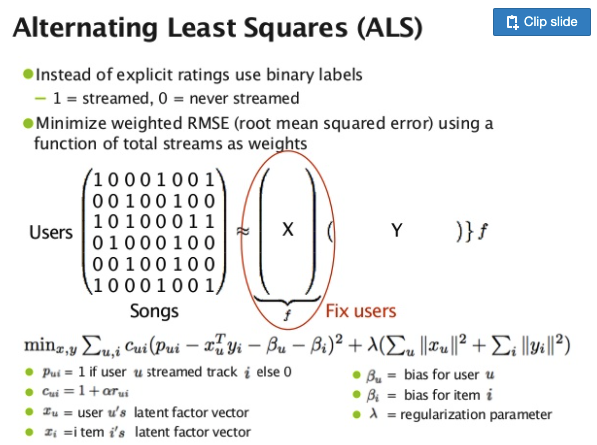

In [9]:
from IPython.display import Image
Image("image/ALS.png")

In [10]:
def ALS_model_training(alpha_val = 40):
    # Build the model for At Least Square matrix factorization model
    ALS_model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

    alpha_val = 40
    data_conf = (csr_matrix * alpha_val).astype('float')

    # Train the model
    ALS_model.fit(data_conf)

    return ALS_model

ALS_model = ALS_model_training()

In [11]:
def get_recommendations_for_playlist_pid(playlist_pid, model=ALS_model):
    row_id_of_playlist = playlists_dict[playlist_pid]

    # Recommendation songs k = test_size * 15 at each playlist
    k = len(test_data[row_id_of_playlist]) * 15
    

    # result for the ALS recommendation: (column_id  (tracks), the score it recommends 0-1))
    recommenations = model.recommend(row_id_of_playlist, csr_matrix, N=k)
    
#     if playlist_pid == 7010:
#         print('original songs in this playlist: ')
#         print(test_data[row_id_of_playlist])
#         print(len(test_data[row_id_of_playlist]))
#         print('k = ', k)
#         print(f'The row id of playlist {playlist_pid} is: {row_id_of_playlist}')
#         print(f'Recommendations: \n {recommenations}')
#         print(f'The precision score for playlist {playlist_pid} is: {r_precision(R, G)}')
    
    return recommenations

print('ALS_model')
get_recommendations_for_playlist_pid(7010)[:3]

ALS_model


[(16129, 0.2688684), (19285, 0.2675972), (2313, 0.26327232)]

## 5.5 Modeling Using Logistic Matrix Factorization (LMF)<a id='5.5_Modeling_Using_LMF'></a>


In [12]:
def LMF_model_training(alpha_val = 40):
    # Build the model for logistic matrix factorization model
    LMF_model = implicit.lmf.LogisticMatrixFactorization(factors=20, regularization=0.1, iterations=20)

    alpha_val = 40
    data_conf = (csr_matrix * alpha_val).astype('float')

    # Train the model
    LMF_model.fit(data_conf)

    return LMF_model

LMF_model = LMF_model_training()

100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


In [13]:
print('LMF_model')
get_recommendations_for_playlist_pid(7010, model=LMF_model)[:3]

LMF_model


[(8922, 21.585447), (14951, 20.830389), (13143, 20.50692)]

## 5.6 Metrics & Evaluation<a id='5.6_Metrics_and_Evaluation'></a>

#### Format the test set as playlist id and column for metric evaluation

In [14]:
# test_data has : key = row_id ( of the playlist), value = list of col_ids ( for tracks)
# playlists_dict has: key = playlist pid, value = row index in matrix
# We use those two dict to map playlist_id -> row_id -> tracks_col_ids

print(f'The length of test set: {len(test_data)}')

print(f'--- Playlist_id = {playlist_id}, row_id = {playlists_dict[playlist_id]}')
print(f'--- Column_track_id = {test_data[ playlists_dict[playlist_id]]}')

The length of test set: 20000
--- Playlist_id = 19999, row_id = 3999
--- Column_track_id = [43866, 36282]


We used the following metrics to evaluate our model, based on Spotify RecSys rules

### 5.6.1 R-Precision<a id='5.6.1_R_Precision'></a>

R-precision is the number of retrieved relevant tracks divided by the number of known relevant tracks (i.e., the number of withheld tracks). This metric rewards total number of retrieved relevant tracks (regardless of order).

In [15]:
# Precision for one playlist (model: ALS)
def r_precision_for_playlist_pid(playlist_pid, model=ALS_model):
    R = { r[0] for r in get_recommendations_for_playlist_pid(playlist_pid, model=model) }
    G = set(test_data[ playlists_dict[playlist_pid]])
    
    return r_precision(R, G)

ALS_total_r_precision = 0
LMF_total_r_precision = 0

for i in range(7000, 7999):
    ALS_total_r_precision += r_precision_for_playlist_pid(i, model=ALS_model)
    LMF_total_r_precision += r_precision_for_playlist_pid(i, model=LMF_model)
    
print(f'ALS_model: The average r-precision score for this dataset(7000, 7999) is : {ALS_total_r_precision/ 1000}')
print(f'LMF_model: The average r-precision score for this dataset(7000, 7999) is : {LMF_total_r_precision/ 1000}')

ALS_model: The average r-precision score for this dataset(7000, 7999) is : 0.00913437312505898
LMF_model: The average r-precision score for this dataset(7000, 7999) is : 0.007591982417590465


In [16]:
ALS_precision_scores = [r_precision_for_playlist_pid(pid, model=ALS_model) for pid in playlists_dict.keys()]
ALS_avg_r_precision = sum(ALS_precision_scores) / len(ALS_precision_scores)
ALS_total_playlists = len(ALS_precision_scores)

LMF_precision_scores = [r_precision_for_playlist_pid(pid, model=LMF_model) for pid in playlists_dict.keys()]
LMF_avg_r_precision = sum(LMF_precision_scores) / len(LMF_precision_scores)
LMF_total_playlists = len(LMF_precision_scores)

print(f'ALS_model: The average r-precision score for this {ALS_total_playlists} playlists is : {round(ALS_avg_r_precision, 4)}')
print(f'LMF_model: The average r-precision score for this {LMF_total_playlists} playlists is : {round(LMF_avg_r_precision, 4)}')

ALS_model: The average r-precision score for this 20000 playlists is : 0.0055
LMF_model: The average r-precision score for this 20000 playlists is : 0.0054


### 5.6.2 Song Clicks<a id='5.6.2_Song_Clicks'></a>

In [17]:
def recs_songs_click(R, G):
    '''
     Recommendation Songs Clicks: measure the index of the first correct recommendation track.
        @param: 
            R: a 'list' of recommendation songs for the playlist giving some seen tracks
            G: a 'set' of the hidden of tracks in the playlist (in the test set)
        @ return: the recommendation songs click value for a given playlist playlist
    '''
    # If no songs that we recommends are not in hidden tracks of the playlist, return click = 51
    clicks = 51
    
    for i in range(len(R)):
        if R[i] in G:
            return i / 10
        
    return clicks

In [18]:
# Song Click for one playlist
def get_recs_songs_clicks_for_pid(playlist_pid, model=ALS_model):
    R = [r[0] for r in get_recommendations_for_playlist_pid(playlist_pid, model=model)]
    G = set(test_data[ playlists_dict[playlist_pid]])
    
    return recs_songs_click(R, G)



In [19]:

# This return the average recommendation songs clicks for all the playlists in the test set --> report this one
ALS_click_scores = [get_recs_songs_clicks_for_pid(pid) for pid in playlists_dict.keys()]

ALS_avg_click_scores = sum(ALS_click_scores) / len(ALS_click_scores)
ALS_total_playlists = len(ALS_click_scores)
print(f'ALS_model: The average recommendation song click score for this {ALS_total_playlists} playlists is : {round(ALS_avg_click_scores, 4)}')

ALS_model: The average recommendation song click score for this 20000 playlists is : 47.8699


In [20]:

# This return the average recommendation songs clicks for all the playlists in the test set --> report this one
LMF_click_scores = [get_recs_songs_clicks_for_pid(pid, model=LMF_model) for pid in playlists_dict.keys()]

LMF_avg_click_scores = sum(LMF_click_scores) / len(LMF_click_scores)
LMF_total_playlists = len(LMF_click_scores)
print(f'LMF_model: The average recommendation song click score for this {LMF_total_playlists} playlists is : {round(LMF_avg_click_scores, 4)}')

LMF_model: The average recommendation song click score for this 20000 playlists is : 47.9051


### 5.6.3 Normalized Discounted Cumulative Gain (NDCG)<a id='5.6.3_Normalized_Discounted_Cumulative_Gain'></a>
Discounted cumulative gain (DCG) measures the ranking quality of the recommended tracks, increasing when relevant tracks are placed higher in the list. Normalized DCG (NDCG) is determined by calculating the DCG and dividing it by the ideal DCG in which the recommended tracks are perfectly ranked.

In [21]:
rec_scores = [r[1] for r in get_recommendations_for_playlist_pid(7010)]
dcg = DCG(rec_scores)
dcg

0.1624210439276419

In [22]:
G = set(test_data[ playlists_dict[7010]])
idcg = IDCG(G)
idcg

9.342075478031335

In [23]:
# The larger NCDG score, the better the recommendations is
NDCG(get_recommendations_for_playlist_pid(7020), set(test_data[ playlists_dict[7020]]) )

0.03528981518255576

In [24]:
def NDCG_for_playlist_pid(playlist_pid, model=ALS_model):
    R = get_recommendations_for_playlist_pid(playlist_pid, model=model)
    G = set(test_data[ playlists_dict[playlist_pid]])
    
    return NDCG(R, G)

In [25]:
# ALS Model NDCG score
'''
ALS_NDCG_scores = []
count = 0
for pid in playlists_dict.keys():
    ALS_NDCG_scores.append(NDCG_for_playlist_pid(pid, model=ALS_model))
    
    if (count % 1000 == 0):
        print(sum(ALS_NDCG_scores) / len(ALS_NDCG_scores))
    
    count += 1

ALS_avg_NDCG = sum(ALS_NDCG_scores) / len(ALS_NDCG_scores)
print(ALS_avg_NDCG)

'''

'\nALS_NDCG_scores = []\ncount = 0\nfor pid in playlists_dict.keys():\n    ALS_NDCG_scores.append(NDCG_for_playlist_pid(pid, model=ALS_model))\n    \n    if (count % 1000 == 0):\n        print(sum(ALS_NDCG_scores) / len(ALS_NDCG_scores))\n    \n    count += 1\n\nALS_avg_NDCG = sum(ALS_NDCG_scores) / len(ALS_NDCG_scores)\nprint(ALS_avg_NDCG)\n\n'

In [26]:
ALS_NDCG_scores = [NDCG_for_playlist_pid(pid, model=ALS_model) for pid in playlists_dict.keys()]
ALS_avg_NDCG = sum(ALS_NDCG_scores) / len(ALS_NDCG_scores)
ALS_avg_NDCG

0.049680662911100154

In [27]:
LMF_NDCG_scores = [NDCG_for_playlist_pid(pid, model=LMF_model) for pid in playlists_dict.keys()]
LMF_avg_NDCG = sum(LMF_NDCG_scores) / len(LMF_NDCG_scores)
LMF_avg_NDCG

0.05215177728292193